# How Anxcor uses XArray to simplify timeseries operations

## Part IV.  Anxcor Processor Class Heirarchy

Up till this point, we've introduced aspects of ```Anxcor``` processor classes, implemented a few of them ourselves, but generally kept the implementation in the realm of pure processing. In this section, we'll dive into the specifics of Anxcor processor classes and show you the range of possibilities for custom functions, as well as the specific contracts your code needs to follow.

### Anxcor Functional Class Design

All of Anxcor's functional classes are designed to 

1) Accept in one or two positional data arguments

2) Accept three keyword-arguments: dask_client, starttime, and station

3) Persist the assumed .attrs metadata attribute between inputs and outputs

4) Operate on a per-window basis

4) Allow for asyncronous file IO before or after the processing step

The result is a scheme where ideally you, the implementer, only need to worry about what your function does, not how it's parallelized, what to persist, or any file IO operations. 

As we saw before, all of our processor classes were created by inheriting from XArrayProcessor, or XArrayRolling. There is an additional variant, AnxcorDataTask, that is meant for pure data handling (i.e. combining datasets or initially loading data). All of these inherit from the base class, AnxcorTask, like so:

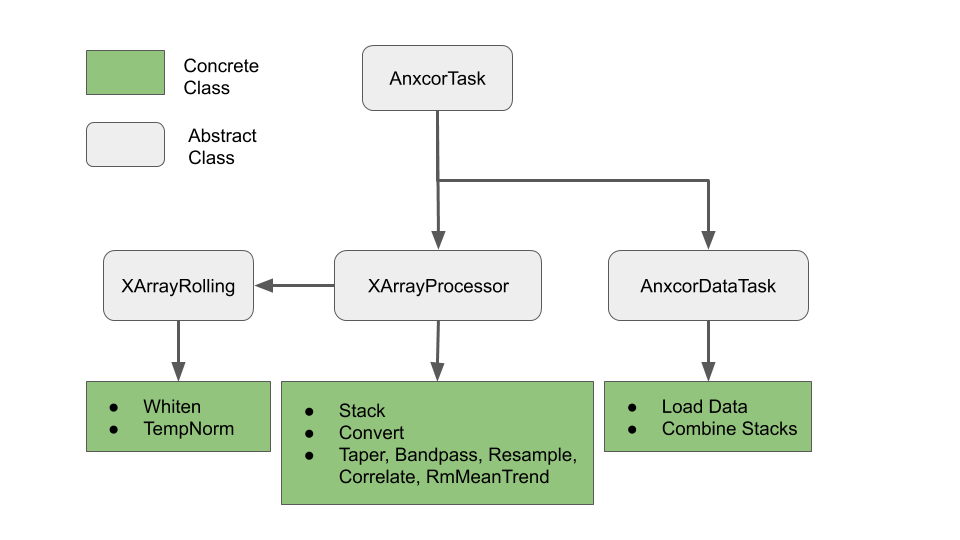

In [1]:
import sys
sys.path.append("../../")
from IPython.display import Image
from IPython.display import display
%matplotlib inline
x = Image(filename='processor_inheritance.png')
display(x)

### Functional and Metadata Overridable Methods

Each of these has a slightly different control flow specific to the needs of the child implementation. Signal processing implementation aside, lets look at the differences between ```AnxcorDataTask```, and ```XArrayProcessor```

In [2]:
from anxcor.abstractions import AnxcorTask
class XArrayProcessor(AnxcorTask):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)

    def _additional_read_processing(self, result):
        if result is not None:
            name   = list(result.data_vars)[0]
            xarray       = result[name].copy()
            xarray.attrs = result.attrs.copy()
            del result
            return xarray
        return result

    def  _should_process(self,xarray, *args):
        return xarray is not None

    def _window_key_convert(self,starttime=0):
        return UTCDateTime(int(starttime*100)/100).isoformat()
    
class AnxcorDataTask(AnxcorTask):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _additional_read_processing(self, result):
        return result


The main differences between the two are the methods:

* ```_additional_read_processing()```: a method which does additional metadata handling after loading data from file. defaults to returning ```result```.

* ```_should_process()```: a method which returns a boolean to decide if the main _single_thread_process() method should execute. defaults to ```True```.

* ```_window_key_convert()```: a method which returns a string used to define file/folder-io structure and method signatures. Defaults to returning  ```window```.

The first two are known as *Functional Overridable Methods* because they have the potential to affect the data processing. The last is known as a *Metadata Overridable Method* because its function is chiefly to provide metadata specific to the implementation. All three methods have defaults which ensure (possibly undesirable) operation even if the methods are not overwritten.

Looking at the bandpass implementation of XArrayProcessor, we see that only three methods are needed for our Functional class to work; ```_single_thread_execute()```, ```_add_operation_string()```, and ```_get_process()```. Under our method definitions, the latter two are metadata overridables, and the first is the functional overridable.

In [3]:
from anxcor.abstractions import XArrayProcessor
import xarray as xr
class XArrayBandpass(XArrayProcessor):
    """
    applies a bandpass filter to a provided xarray
    """

    def __init__(self,upper_frequency=10.0,
                    lower_frequency=0.001,
                    order=2,
                    taper=0.01,**kwargs):
        super().__init__(**kwargs)
        self._kwargs = {'upper_frequency':upper_frequency,
                        'lower_frequency':lower_frequency,
                        'order':order,
                        'taper':taper}

    def _launch_process(self, xarray: xr.DataArray,*args, **kwargs):
        sampling_rate = 1.0 / xarray.attrs['delta']
        ufunc_kwargs = {**self._kwargs}

        if self._kwargs['upper_frequency'] > sampling_rate / 2:
            ufunc_kwargs['upper_frequency'] = sampling_rate / 2

        filtered_array = xr.apply_ufunc(filt_ops.taper_func, xarray,
                                        input_core_dims=[['time']],
                                        output_core_dims=[['time']],
                                        kwargs={**self._kwargs})
        filtered_array = xr.apply_ufunc(filt_ops.bandpass_in_time_domain_sos, filtered_array,
                                        input_core_dims=[['time']],
                                        output_core_dims=[['time']],
                                        kwargs={**ufunc_kwargs,**{
                                                'sample_rate': sampling_rate}})

        return filtered_array

    def _add_operation_string(self):
        return 'bandpass@{}<x(t)<{}'.format(self._kwargs['lower_frequency'],
                                       self._kwargs['upper_frequency'])

    def _get_process(self):
        return 'bandpass'

Given these three methods, lets implement a basic 'one bit normalization' technique:

/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)
/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):
/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converter

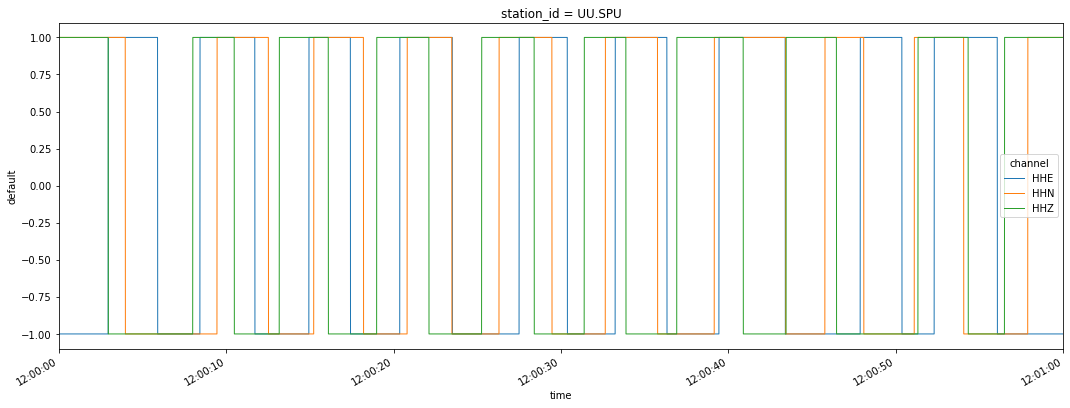

In [4]:
from anxcor.abstractions import XArrayProcessor
import numpy as np
class XArrayOneBit(XArrayProcessor):
    """
    one bit normalization
    """

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def _launch_process(self, xarray: xr.DataArray,*args, **kwargs):
        return np.sign(xarray)

    def _add_operation_string(self):
        return 'one-bit-norm'

    def _get_process(self):
        return 'one-bit-norm'
    
from anxcor.xarray_routines import XArrayConverter
from obspy.clients.fdsn import Client
from anxcor.anxcor_utils import remove_response
from obspy.core import UTCDateTime
import matplotlib.pyplot as plt
%matplotlib inline

client = Client("IRIS")
t  = UTCDateTime("2018-12-25 12:00:00").timestamp
st = client.get_waveforms("UU", "SPU", "*", "H*", t, t + 60,attach_response=True)
st.detrend(type='linear')
st.detrend(type='constant')
st.taper(0.05)
pre_filt = (0.03, 0.05, 40.0, 45.0)
st=remove_response(st, output='DISP', pre_filt=pre_filt)
converter = XArrayConverter()
onebitter = XArrayOneBit()
xarray_data = converter(st)
onebit_data = onebitter(xarray_data)
xarray_squeezed = onebit_data.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

### Anxcor Data Tasks

While ```XArrayRolling``` and ```XArrayProcessor``` classes are designed to transform in-RAM xarray-to-xarray objects, ```AnxcorDataTasks``` operate under the assumptions that no read-writing of data is needed. Two processing steps have this kind of requirement:

1) Reading data from disk. 
2) Concatenation of xarrays after crosscorrelation. 

```Anxcor``` implements these tasks under the hood during a crosscorrelation operation, so no user implementation of these classes is necessary (or advised).

## Anxcor Database

A strong motivating factor for creating ```Anxcor``` was the fact that many scientists organize their data differently. Directory structures often encode metadata like ```station_id```s, ```network```, ```starttimes```, and processing steps. Such heterogeneity is unavoidable with a small ambient noise tomography community, but at the very least it would help reproducibility and training if the differences in file storage could be abstracted away from the processing implementation.

```Anxcor``` requires the user to define a database class implementing the ```AnxcorDatabase``` interface. The interface requires the user to implement two methods:

* ```get_stations(self)-> List[str]:``` returns a list of all stations within the database, formatted as 
```python
'{}.{}'.format(network,station)
```
for every object

* ```get_waveforms(self,network: str = None, station: str = None, starttime: float = 0, endtime: float = 0,**kwargs)->Stream:``` returns an ```ObsPy``` ```Stream``` object, with the relevant station, network, starttime and endtime floats formatted as ```UTCDateTime.timestamp```s. 

When ```Anxcor``` calls an ```AnxcorDatabase``` implementation, it expects to receive a list of stations corresponding to all data accessible by the implementation via ```get_stations()```, and expects the returned ```Stream``` from ```get_waveforms()``` will contain all channels corresponding to the provided keyword query. Additionally, these ```Stream``` objects **MUST span the asked for starttime-stoptime range, there must be NO GAPS**! If the implementation cannot adhere by these rules, it is sufficient to return a ```None``` object.

Of course, this means that you, the user, will have to implement such a database class yourself depending on your data format. Lets explore an example of this, starting from the stream we downloaded earlier, ```st```

In [17]:
def save_stream_to_file(stream):
    for trace in st:
    # formatted as 'network.station.channel.starttime.sac'
        file_name = '{}.{}.{}.{}.sac'.format(trace.stats.network,
                                         trace.stats.station, 
                                         trace.stats.channel, 
                                         trace.stats.starttime.format_iris_web_service())
        trace.write(file_name)
        print(file_name)
        
save_stream_to_file(st)

UU.SPU.HHE.2018-12-25T12:00:00.000.sac
UU.SPU.HHN.2018-12-25T12:00:00.000.sac
UU.SPU.HHZ.2018-12-25T12:00:00.000.sac


In [13]:
from anxcor.containers import AnxcorDatabase
from obspy import read
from obspy.core import Stream
import os
import glob

class AnxcorDatabaseImplementation(AnxcorDatabase):

    def __init__(self):
        super().__init__()

    def get_stations(self):
        sac_files = glob.glob('*.sac')
        stations=[]
        for file in sac_files:
            file_parts = file.split('.')
            stations.append(file_parts[0]+'.'+file_parts[1])
        return set(stations)
    
    def get_waveforms(self,network=None, station=None,starttime=0,endtime=0):
        files = self._get_potential_files(network,station,starttime,endtime)
        if not files:
            return None
        
        obspy_stream = Stream()
        for file in files:
            obspy_stream+=read(file)
        obspy_stream.trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))
        obspy_stream.taper(0.05)
        return obspy_stream
            
    def _get_potential_files(self,network,station,starttime,endtime):
        # in order to be a candidate file, both starttime and endtime have to be castable to the hour mark
        start_file_time = UTCDateTime(self._cast_to_nearest_hour(starttime)).format_iris_web_service()
        end_file_time   = UTCDateTime(self._cast_to_nearest_hour(endtime)).format_iris_web_service()
        start_files     = glob.glob('*{}.{}.*.{}.sac'.format(network,station,start_file_time))
        end_files       = glob.glob('*{}.{}.*.{}.sac'.format(network,station,end_file_time))
        potential_files = []
        for start_file in start_files:
            if start_file in end_files:
                potential_files.append(start_file)
        return potential_files
        
    def _cast_to_nearest_hour(self,floattime):
        return int(floattime/3600)*3600.0

In [14]:
database = AnxcorDatabaseImplementation()
print(database.get_stations())
database.get_waveforms(network='UU', station='SPU',starttime=t+25,endtime=t+40)

{'UU.SPU'}


3 Trace(s) in Stream:
UU.SPU.01.HHN | 2018-12-25T12:00:25.000000Z - 2018-12-25T12:00:40.000000Z | 100.0 Hz, 1501 samples
UU.SPU.01.HHE | 2018-12-25T12:00:25.000000Z - 2018-12-25T12:00:40.000000Z | 100.0 Hz, 1501 samples
UU.SPU.01.HHZ | 2018-12-25T12:00:25.000000Z - 2018-12-25T12:00:40.000000Z | 100.0 Hz, 1501 samples

Here we can see that forcing database to adhere to the ```AnxcorDatabase``` contract provides a clean way to access waveform data. 

In your workflow, this is the last time your processing functions will have access to modifying the ```Stream``` object. So, if you intend to remove the response based on ```Stream``` metadata, do it here. Here's a modification of ```AnxcorDatabaseImplementation``` to do just that.

In [ ]:
from anxcor.anxcor_utils import remove_response

class AnxcorDatabaseImplementation(AnxcorDatabase):

    def __init__(self):
        super().__init__()
        self.pre_filt = (0.03, 0.05, 40.0, 45.0)
        
    def get_stations(self):
        sac_files = glob.glob('*.sac')
        stations=[]
        for file in sac_files:
            file_parts = file.split('.')
            stations.append(file_parts[0]+'.'+file_parts[1])
        return stations
    
    def get_waveforms(self,network=None, station=None,starttime=0,endtime=0):
        files = self._get_potential_files(network,station,starttime,endtime)
        if not files:
            return None
        
        obspy_stream = Stream()
        for file in files:
            obspy_stream+=read(file)
            
        obspy_stream.taper(0.05) 
        st=remove_response(st, output='DISP', pre_filt=self.pre_filt)
        obspy_stream.trim(starttime=UTCDateTime(starttime), endtime=UTCDateTime(endtime))
        obspy_stream.taper(0.05)
        return obspy_stream
            
    def _get_potential_files(self,network,station,starttime,endtime):
        # in order to be a candidate file, both starttime and endtime have to be castable to the hour mark
        start_file_time = UTCDateTime(self._cast_to_nearest_hour(starttime)).format_iris_web_service()
        end_file_time   = UTCDateTime(self._cast_to_nearest_hour(endtime)).format_iris_web_service()
        start_files     = glob.glob('*{}.{}.*.{}.sac'.format(network,station,start_file_time))
        end_files       = glob.glob('*{}.{}.*.{}.sac'.format(network,station,end_file_time))
        potential_files = []
        for start_file in start_files:
            if start_file in end_files:
                potential_files.append(start_file)
        return potential_files
        
    def _cast_to_nearest_hour(self,floattime):
        return int(floattime/3600)*3600.0

In [18]:
client = Client("IRIS")
t  = UTCDateTime("2018-12-25 12:00:00").timestamp
st = client.get_waveforms("UU", "SPU", "*", "H*", t, t + 60,attach_response=True)
save_stream_to_file(st)

database = AnxcorDatabaseImplementation()
print(database.get_stations())
database.get_waveforms(network='UU', station='SPU',starttime=t+25,endtime=t+40)

UU.SPU.HHE.2018-12-25T12:00:00.000.sac
UU.SPU.HHN.2018-12-25T12:00:00.000.sac
UU.SPU.HHZ.2018-12-25T12:00:00.000.sac
{'UU.SPU'}


3 Trace(s) in Stream:
UU.SPU.01.HHN | 2018-12-25T12:00:25.000000Z - 2018-12-25T12:00:40.000000Z | 100.0 Hz, 1501 samples
UU.SPU.01.HHE | 2018-12-25T12:00:25.000000Z - 2018-12-25T12:00:40.000000Z | 100.0 Hz, 1501 samples
UU.SPU.01.HHZ | 2018-12-25T12:00:25.000000Z - 2018-12-25T12:00:40.000000Z | 100.0 Hz, 1501 samples

Now we have everything we need to set up a crosscorrelation task with ```anxcor```